In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import pairwise_distances

pd.set_option('display.max_rows', 100)

In [3]:
train_df = pd.read_csv('./data/train.csv')
train_df.drop_duplicates(inplace=True)
print(f'Number of rows: {train_df.shape[0]}')
train_df.head()

Number of rows: 59727


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


# Distance to good schools

In [4]:
school_df = pd.read_csv('./data/auxiliary-data/sg-primary-schools-processed.csv')
school_df.rename(columns={'name': 'School'}, inplace=True)
school_df.head()

,School,latitude,longitude
0,Admiralty,1.454038,103.817436
1,Ahmad Ibrahim,1.433153,103.832942
2,Ai Tong,1.360583,103.833020
3,Alexandra,1.291334,103.824425
4,Anchor Green,1.390370,103.887165


In [5]:
ballot_df = pd.read_csv('./data/auxiliary-data/sg-school-balloting-processed.csv')
ballot_df.head()

,School,Phase 1,2A,2B,2C
0,Admiralty,0.500000,0.426667,1.088235,1.557143
1,Ahmad Ibrahim,0.337500,0.094340,0.000000,0.171975
2,Ai Tong,0.475000,0.952381,2.545455,1.733333
3,Alexandra,0.407143,0.156627,0.093023,1.110236
4,Anchor Green,0.472222,0.315789,0.000000,0.281250


In [6]:
ballot_df = ballot_df.merge(school_df, on='School', how='left')
ballot_df.head()

,School,Phase 1,2A,2B,2C,latitude,longitude
0,Admiralty,0.500000,0.426667,1.088235,1.557143,1.454038,103.817436
1,Ahmad Ibrahim,0.337500,0.094340,0.000000,0.171975,1.433153,103.832942
2,Ai Tong,0.475000,0.952381,2.545455,1.733333,1.360583,103.833020
3,Alexandra,0.407143,0.156627,0.093023,1.110236,1.291334,103.824425
4,Anchor Green,0.472222,0.315789,0.000000,0.281250,1.390370,103.887165


In [7]:
ballot_df.describe()

,Phase 1,2A,2B,2C,latitude,longitude
count,181.000000,181.000000,181.000000,181.000000,179.000000,179.000000
mean,0.456942,0.544013,0.457793,1.034816,1.363490,103.842167
std,0.133276,0.456326,0.678807,0.887193,0.043206,0.070086
min,0.155556,0.049180,0.000000,0.075630,1.274958,103.687950
25%,0.350000,0.198113,0.000000,0.371622,1.334409,103.787187
50%,0.470833,0.407407,0.071429,0.901961,1.357909,103.844240
75%,0.552381,0.788732,0.700000,1.400000,1.391291,103.898803
max,0.800000,3.543478,3.400000,5.895833,1.456608,103.961677


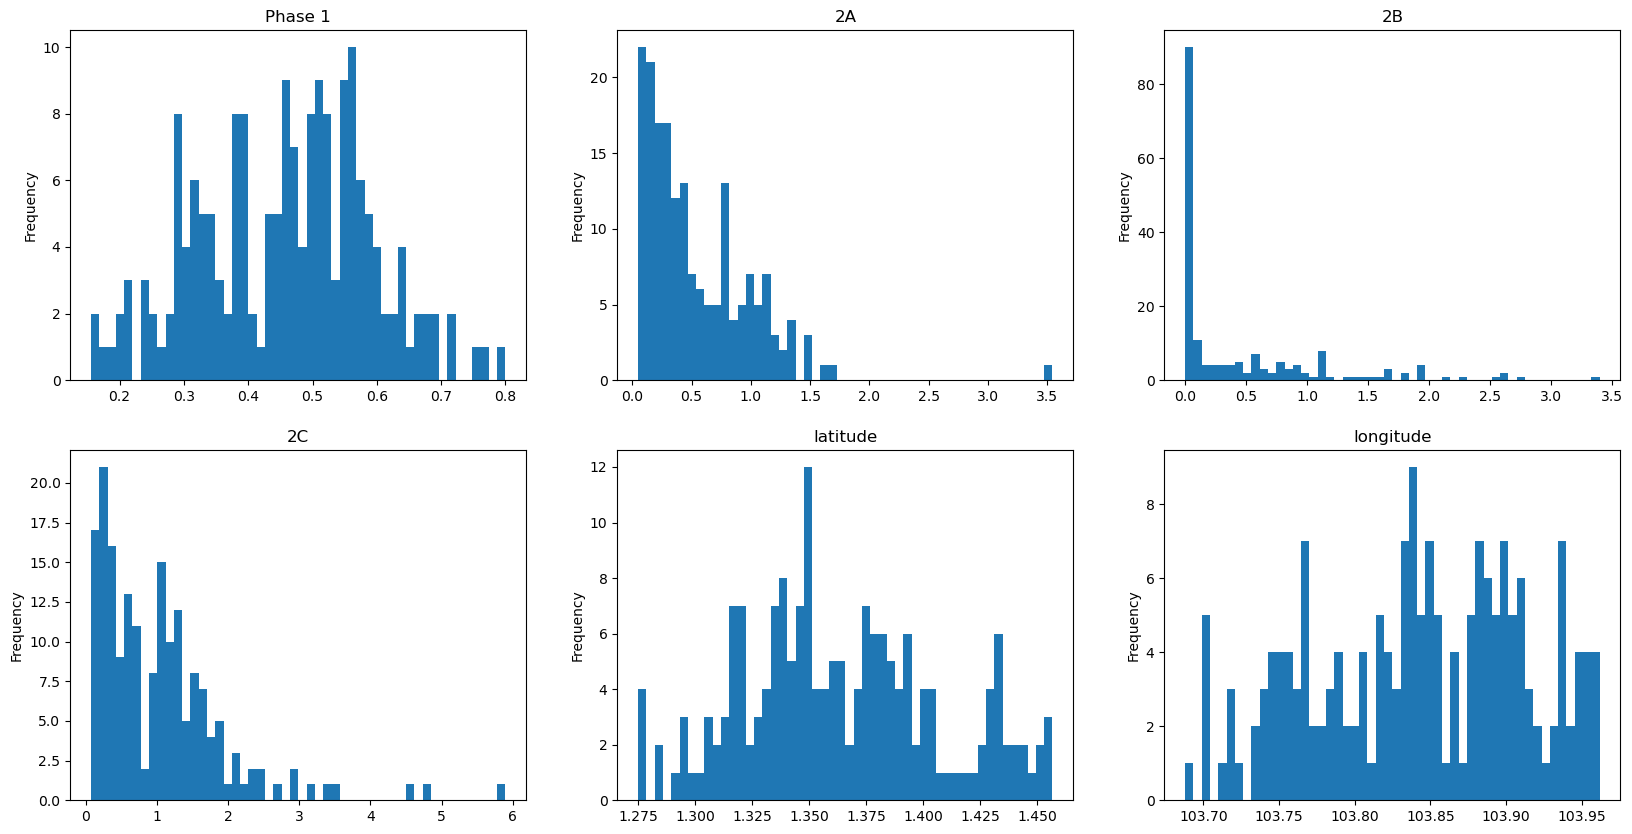

In [8]:
cols = ballot_df.columns[1:]
n = len(cols) // 2
fig,ax = plt.subplots(2, n, figsize=(20, 10))
for i, col in enumerate(cols):
    ballot_df[col].plot(ax=ax[i//n, i%n], kind='hist', bins=50)
    ax[i//n, i%n].set_title(col)

In [9]:
top_threshold = 1.8
good_threshold = 1.0

In [10]:
top_schools = ballot_df[(ballot_df['2B'] >= top_threshold) | (ballot_df['2C'] >= top_threshold)]
print(len(top_schools))
top_schools

31


,School,Phase 1,2A,2B,2C,latitude,longitude
2,Ai Tong,0.475000,0.952381,2.545455,1.733333,1.360583,103.833020
8,Anglo-Chinese,0.311111,0.854839,1.961538,1.283019,1.318371,103.835610
15,Bukit Panjang,0.555556,0.975000,1.142857,2.119048,1.373622,103.769375
23,CHIJ (Toa Payoh),0.340000,0.780000,1.962963,1.254545,1.332753,103.841847
24,CHIJ St. Nicholas Girls,0.466667,1.287500,2.300000,2.100000,1.373979,103.834240
47,Fairfield Methodist,0.552381,1.095745,2.600000,1.650000,1.301004,103.785456
58,Gongshang,0.712500,3.543478,0.800000,2.431818,1.357116,103.949145
64,Holy Innocents,0.509524,1.116505,2.650000,2.875000,1.366938,103.894115
65,Hong Wen,0.546667,0.492754,0.937500,2.188406,1.321760,103.857628
66,Horizon,0.572222,1.363636,0.800000,1.840909,1.399550,103.913405


In [11]:
good_schools = ballot_df[((ballot_df['2B'] < top_threshold) & (ballot_df['2C'] < top_threshold)) & ((ballot_df['2B'] >= good_threshold) | (ballot_df['2C'] >= good_threshold))]
print(len(good_schools))
good_schools

54


,School,Phase 1,2A,2B,2C,latitude,longitude
0,Admiralty,0.500000,0.426667,1.088235,1.557143,1.454038,103.817436
3,Alexandra,0.407143,0.156627,0.093023,1.110236,1.291334,103.824425
5,Anderson,0.473333,0.582278,0.612903,1.243243,1.384264,103.841392
7,Anglo-Chinese (Junior),0.361905,0.753731,1.677419,1.274194,1.309350,103.840950
9,Angsana,0.400000,0.719697,0.062500,1.757895,1.348553,103.951808
22,CHIJ Our Lady of the Nativity,0.333333,0.200000,0.865385,1.018018,1.373574,103.897769
25,Canberra,0.444444,0.160000,0.458333,1.073770,1.451250,103.815859
26,Canossa Catholic,0.800000,0.250000,0.826087,1.120000,1.326644,103.882228
29,Catholic High,0.355556,1.163793,1.450000,1.300000,1.354389,103.844211
32,Chongfu,0.508333,0.618644,1.514286,1.555556,1.438396,103.839309


In [12]:
normal_schools = ballot_df[((ballot_df['2B'] < good_threshold) & (ballot_df['2C'] < good_threshold))]
print(len(normal_schools))
normal_schools

96


,School,Phase 1,2A,2B,2C,latitude,longitude
1,Ahmad Ibrahim,0.337500,0.094340,0.000000,0.171975,1.433153,103.832942
4,Anchor Green,0.472222,0.315789,0.000000,0.281250,1.390370,103.887165
6,Ang Mo Kio,0.355556,0.568966,0.000000,0.341176,1.365588,103.850957
10,Beacon,0.666667,0.200000,0.000000,0.369048,1.383949,103.773632
11,Bedok Green,0.380000,0.117021,0.000000,0.188811,1.323446,103.937879
12,Bendemeer,0.276923,0.127660,0.021277,0.209790,1.321813,103.865404
13,Blangah Rise,0.383333,0.540541,0.000000,0.233766,1.276120,103.808629
14,Boon Lay Garden,0.383333,0.202703,0.000000,0.223140,1.343179,103.713281
16,Bukit Timah,0.533333,0.125000,0.027778,0.639640,1.337300,103.766829
17,Bukit View,0.238462,0.085859,0.000000,0.111570,1.345861,103.753666


In [17]:
top_dists = pairwise_distances(train_df[['latitude', 'longitude']].values, top_schools[['latitude', 'longitude']].values)

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

# Convert lease_commence_date to age and discretise to bins

<Axes: ylabel='Frequency'>

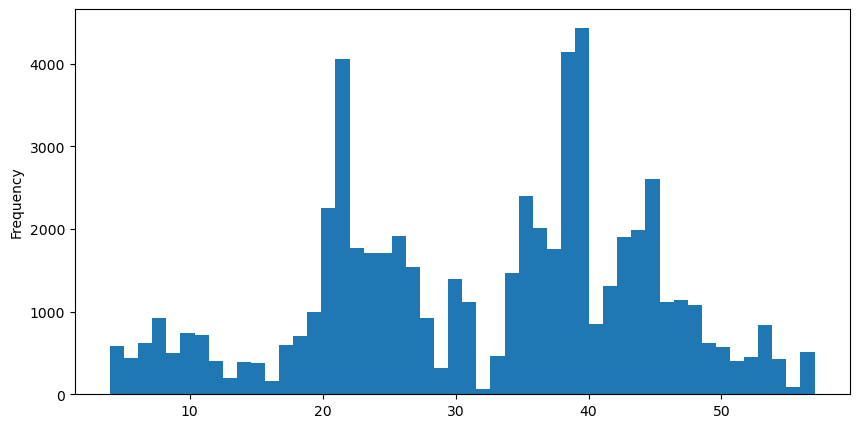

In [14]:
train_df['age'] = train_df['lease_commence_date'].apply(lambda x: 2023 - x)
train_df.drop(columns=['lease_commence_date'], inplace=True)
train_df['age'].plot(kind='hist', bins=50, figsize=(10, 5))

<Axes: ylabel='Frequency'>

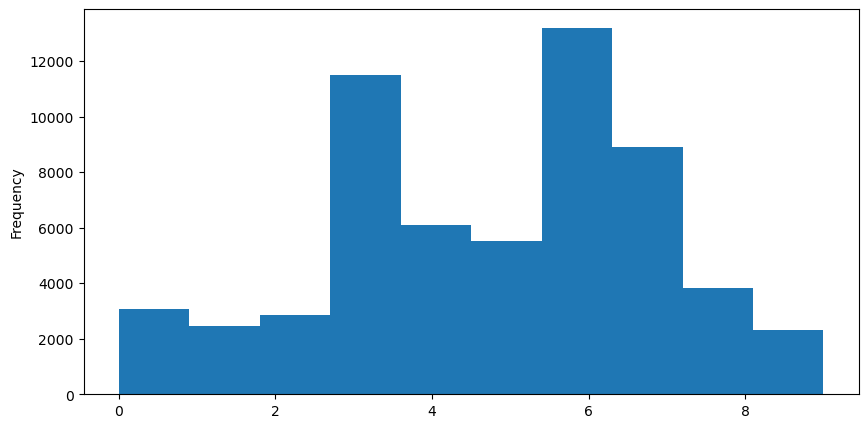

In [15]:
n_age_bins = 10
age_KBD = KBinsDiscretizer(n_bins=n_age_bins, encode='ordinal', strategy='uniform')
age_KBD.fit(train_df[['age']])
age_KBD.bin_edges_
train_df['age_bin'] = age_KBD.transform(train_df[['age']])
train_df['age_bin'].plot(kind='hist', bins=n_age_bins, figsize=(10, 5))